In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from skimage import transform

In [2]:
def prepare_data(train_data, train_label, memory_unit, batch_size):
    number, height, width, channel = \
    train_data.shape[0], train_data.shape[1], train_data.shape[2], train_data.shape[3]

    number_of_mem_unit = number // memory_unit

    # let the data become from (1200, 80, 160, 1) to (40, 30, 80 * 160)
    sample_number = number_of_mem_unit * memory_unit
    unit_train_data = train_data[0: sample_number, :, :, :].reshape(-1, batch_size, memory_unit, height * width)
    
    # label shift to right by one step
    unit_train_label = train_label[0: sample_number, :, :, :].reshape(-1, batch_size, memory_unit, height * width)
    
    return iter(unit_train_data), iter(unit_train_label)


In [3]:
# Example of formatting
labels = pickle.load(open("full_CNN_labels.p", "rb" ))
labels = np.array(labels)[0:12000,:,:,:]
labels = labels / 255
print(labels.shape)
print(labels.reshape(-1, 20, 30, 80 * 160).shape)

(12000, 80, 160, 1)
(20, 20, 30, 12800)


In [4]:
datalist = pickle.load(open("full_CNN_labels.p", "rb" ))
data = np.array([transform.resize(i, (40, 80)) for i in datalist])
labellist = pickle.load(open("full_CNN_labels.p", "rb" ))
label = np.array([transform.resize(i, (40, 80)) for i in labellist])

label = label / 255

train_ratio = 0.8
memory_size = 30
batch_size = 5
train_data, test_data, train_label, test_label = \
train_test_split(data, label, train_size = train_ratio,
                              test_size = 1 - train_ratio,
                              shuffle = False)

input_data_iter, input_label_iter = prepare_data(train_data, train_label, memory_size, batch_size)

/home/spencer/Documents/MachineLearning/project_venv/local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
#Cell used to training

learning_rate = 0.001

#Size of our input image. e.g. number of features
number_of_features = 40 * 80

steps_num = 100

#input data
X = tf.placeholder(tf.float32, [None, memory_size, number_of_features])
#data label
Y = tf.placeholder(tf.float32, [None, memory_size, number_of_features])

#RNN cells
cell = tf.contrib.rnn.BasicLSTMCell(number_of_features, activation=tf.nn.relu)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

#loss
loss = tf.reduce_mean(tf.square(outputs - Y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    for iteration in range(steps_num):
        try:
            train_data, train_labels = next(input_data_iter), next(input_label_iter)
        except StopIteration:
            print('Stopping iteration - no more input data')
            break
        sess.run(train, feed_dict = {X:train_data, Y:train_labels})
        error = loss.eval( feed_dict = {X:train_data, Y:train_labels})
        print("iteration {}, error is {}".format(iteration, error))
        print("\n")
    saver.save(sess, save_path="./tmp/rnn_model/rnn_model")

iteration 0, error is 1.1742851734161377


iteration 1, error is 34.55853271484375


iteration 2, error is 0.09333569556474686


iteration 3, error is 0.43326711654663086


iteration 4, error is 0.2141987681388855


iteration 5, error is 0.0921424999833107


iteration 6, error is 0.10928470641374588


iteration 7, error is 0.13034361600875854


iteration 8, error is 0.14761574566364288


iteration 9, error is 0.06932304799556732


iteration 10, error is 0.06694496423006058


iteration 11, error is 0.07053373754024506


iteration 12, error is 0.05305713787674904


iteration 13, error is 0.08301123976707458


iteration 14, error is 0.05286582186818123


iteration 15, error is 0.033030178397893906


iteration 16, error is 0.025198614224791527


iteration 17, error is 0.019048355519771576


iteration 18, error is 0.017042208462953568


iteration 19, error is 0.02304205298423767


iteration 20, error is 0.019740501418709755


iteration 21, error is 0.01985456608235836


iteration 22, error 

INFO:tensorflow:Restoring parameters from ./tmp/rnn_model/rnn_model


/home/spencer/Documents/MachineLearning/project_venv/local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7177


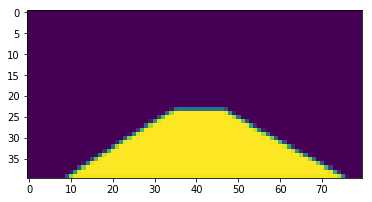

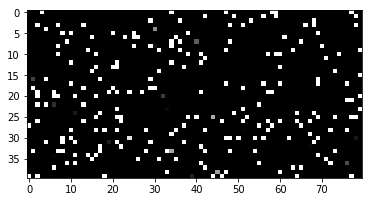

In [7]:
import matplotlib.image as mpimg

train_images_raw = pickle.load(open("full_CNN_labels.p", "rb" ))
I = np.array([transform.resize(i, (40, 80)) for i in train_images_raw[500:530]]).reshape(-1, 30, 3200)

# Cell used to predicting
with tf.Session() as sess:
    saver.restore(sess, "./tmp/rnn_model/rnn_model")
    # input data used to predict, format:
    x_input = I
    # The output should be a 1-D array whose size is height * width. 
    # In order to display it, it needs reshpe
    y_pred = sess.run(outputs, feed_dict={X:x_input})
    print(np.count_nonzero(y_pred))
    
    I = I.reshape(-1, 40, 80)

    plt.figure()
    plt.imshow(I[29])
    
    P = y_pred.reshape(-1, 40, 80)[29] * 255
    P1 = np.zeros((40,80,3))
    P1 = np.moveaxis(np.tile(P, (3, 1, 1)),0,-1)

    plt.figure()
    plt.imshow(P1)